In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

/Users/victor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Retrieving the last values

In [2]:
traffic_reel = pd.read_csv('to_predict_traffic.csv', delimiter = ',') # do we want older or more recent data ?

traffic_reel = traffic_reel.rename(columns={"timestamp":"Date et heure de comptage"})

traffic_reel["Date et heure de comptage"] = pd.to_datetime(traffic_reel["Date et heure de comptage"], utc=True)

traffic_reel = traffic_reel.sort_values(by=["Date et heure de comptage"], ascending=True)

traffic_reel = traffic_reel.rename(columns={"Débit horaire": "Real Debit"})

traffic_reel


,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Real Debit,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,number_markets,ongoing_market,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
8952,8952,2022-11-01 03:00:00+00:00,5672,Convention,34.0,0.28667,Fluide,2973,Convention-Blomet,2937,...,4.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,0.707107,0.707107
8646,8646,2022-11-01 03:00:00+00:00,191,Sts_Peres,220.0,2.54722,Fluide,114,Sts_Peres-Voltaire,119,...,NaN,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,0.707107,0.707107
7299,7299,2022-11-01 03:00:00+00:00,4264,AV_Champs_Elysees,672.0,8.89223,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,0.707107,0.707107
7298,7298,2022-11-01 04:00:00+00:00,4264,AV_Champs_Elysees,513.0,7.12889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,0.500000,0.866025
8951,8951,2022-11-01 04:00:00+00:00,5672,Convention,54.0,0.44611,Fluide,2973,Convention-Blomet,2937,...,4.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26847,26847,2023-11-30 22:00:00+00:00,4264,AV_Champs_Elysees,950.0,16.66334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,2.0,0,0.885456,-0.464723,-0.222521,-0.974928,0.860961,-0.508671,0.866025,-0.500000
27574,27574,2023-11-30 22:00:00+00:00,5672,Convention,87.0,1.99778,Fluide,2973,Convention-Blomet,2937,...,1.0,0,0.885456,-0.464723,-0.222521,-0.974928,0.860961,-0.508671,0.866025,-0.500000
27410,27410,2023-11-30 23:00:00+00:00,191,Sts_Peres,498.0,4.32723,Fluide,114,Sts_Peres-Voltaire,119,...,NaN,0,0.885456,-0.464723,-0.222521,-0.974928,0.860961,-0.508671,0.965926,-0.258819
22546,22546,2023-11-30 23:00:00+00:00,4264,AV_Champs_Elysees,863.0,13.60389,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,2.0,0,0.885456,-0.464723,-0.222521,-0.974928,0.860961,-0.508671,0.965926,-0.258819


# Creating a Baseline Model

In [2]:
traffic_final_imp = pd.read_csv('traffic_final.csv', delimiter = ',') # do we want older or more recent data ?
traffic_final_imp = traffic_final_imp.rename(columns={"timestamp":"Date et heure de comptage"})
traffic_final_imp.head()


,Unnamed: 0,Libelle,arrondissement,Débit horaire,Taux d'occupation,Date et heure de comptage,temp,humidity,rain,wind_speed,...,ongoing_market,year_day,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
0,0,AV_Champs_Elysees,75008,764.0,11.28000,2023-02-01 22:00:00+00:00,6.733333,76.000000,0.0,3.133333,...,0,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.866025,-0.500000
1,1,AV_Champs_Elysees,75008,819.0,16.52056,2023-02-01 21:00:00+00:00,7.400000,73.000000,0.0,3.300000,...,0,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.707107,-0.707107
2,2,AV_Champs_Elysees,75008,1082.0,19.98722,2023-02-01 19:00:00+00:00,8.066667,67.000000,0.0,3.566667,...,1,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,0.258819,-0.965926
3,3,AV_Champs_Elysees,75008,1027.0,23.27334,2023-02-01 17:00:00+00:00,8.266667,65.111111,0.0,3.622222,...,1,32,0.822984,0.568065,-0.900969,-0.433884,0.852078,0.523416,-0.258819,-0.965926
4,4,Sts_Peres,75007,257.0,3.04445,2023-08-09 22:00:00+00:00,16.533333,83.333333,0.0,0.633333,...,0,221,-0.748511,-0.663123,-0.900969,-0.433884,-0.788305,-0.615285,0.866025,-0.500000


In [3]:
champs = traffic_final_imp[traffic_final_imp['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["Date et heure de comptage"], ascending=True)
st_peres = traffic_final_imp[traffic_final_imp['Libelle'] == "Sts_Peres"].sort_values(by=["Date et heure de comptage"], ascending=True)
convention = traffic_final_imp[traffic_final_imp['Libelle'] == "Convention"].sort_values(by=["Date et heure de comptage"], ascending=True)


In [7]:
class BaselineAverage:
    def __init__(self):
        self.average_value = None

    def fit(self, time_series):
        # Calculate the average value of the time series
        self.average_value = time_series.mean()

    def predict(self, forecast_dates):
        # Check if the model has been fitted
        if self.average_value is None:
            raise ValueError("Model has not been fitted. Call fit() first.")

        # Create a DataFrame with forecast dates and corresponding average value predictions
        forecast_df = pd.DataFrame({
            'Date et heure de comptage': forecast_dates,
            'Débit horaire': [self.average_value] * len(forecast_dates)
        })
        forecast_df["Date et heure de comptage"] = pd.to_datetime(forecast_df["Date et heure de comptage"], utc=True)

        return forecast_df

In [8]:
baseline_model = BaselineAverage()
baseline_model.fit(champs['Débit horaire'])

In [9]:
date_range = pd.date_range(start='2023-12-01', end='2023-12-04', freq='H')

formatted_dates = date_range.strftime('%Y-%m-%dT%H:%M:%S%z')

predictions = baseline_model.predict(formatted_dates)

predictions

,Date et heure de comptage,Débit horaire
0,2023-12-01 00:00:00+00:00,884.490328
1,2023-12-01 01:00:00+00:00,884.490328
2,2023-12-01 02:00:00+00:00,884.490328
3,2023-12-01 03:00:00+00:00,884.490328
4,2023-12-01 04:00:00+00:00,884.490328
...,...,...
68,2023-12-03 20:00:00+00:00,884.490328
69,2023-12-03 21:00:00+00:00,884.490328
70,2023-12-03 22:00:00+00:00,884.490328
71,2023-12-03 23:00:00+00:00,884.490328


In [23]:
predictions_without = predictions.drop(predictions.index[-2:])

merged_df = pd.merge(traffic_reel, predictions_without, on='Date et heure de comptage')

# Calculate the Mean Squared Error
mse = mean_squared_error(merged_df['Débit horaire'], merged_df['Real Debit'])
rmse = math.sqrt(mse)
print(rmse)

452.7154091167117


In [10]:
traffic_reel_formatted = traffic_reel.rename(columns={"Real Debit":"Débit horaire"})
reel_values = pd.concat([champs[['Débit horaire', 'Date et heure de comptage']], traffic_reel_formatted], ignore_index=True)
reel_values["Date et heure de comptage"] = pd.to_datetime(reel_values["Date et heure de comptage"], utc=True)

reel_values


,Débit horaire,Date et heure de comptage
0,672.0,2022-11-01 03:00:00+00:00
1,513.0,2022-11-01 04:00:00+00:00
2,494.0,2022-11-01 05:00:00+00:00
3,513.0,2022-11-01 06:00:00+00:00
4,484.0,2022-11-01 07:00:00+00:00
...,...,...
9380,1464.0,2023-12-03 18:00:00+00:00
9381,1385.0,2023-12-03 19:00:00+00:00
9382,1200.0,2023-12-03 20:00:00+00:00
9383,1266.0,2023-12-03 21:00:00+00:00


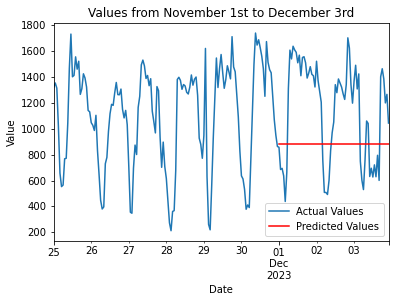

In [25]:
start_date = '2023-11-25'
end_date = '2023-12-04'
df_filtered = reel_values[(reel_values['Date et heure de comptage'] >= start_date) & (reel_values['Date et heure de comptage'] <= end_date)]


ax = df_filtered.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Actual Values', linestyle='-')

predictions_without.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Predicted Values', linestyle='-', color='red', ax=ax)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Values from November 1st to December 3rd')
plt.show()

# Testing an XG Boost Model

In [26]:
champs.head()

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,number_markets,ongoing_market,cos_week,sin_week,cos_weekday,sin_weekday,cos_year_day,sin_year_day,cos_timestamp_hour,sin_timestamp_hour
7299,7299,2022-11-01 03:00:00+00:00,4264,AV_Champs_Elysees,672.0,8.89223,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,7.071068e-01,0.707107
7298,7298,2022-11-01 04:00:00+00:00,4264,AV_Champs_Elysees,513.0,7.12889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,5.000000e-01,0.866025
7297,7297,2022-11-01 05:00:00+00:00,4264,AV_Champs_Elysees,494.0,6.22500,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,0,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,2.588190e-01,0.965926
8665,8665,2022-11-01 06:00:00+00:00,4264,AV_Champs_Elysees,513.0,5.80723,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,6.123234e-17,1.000000
7296,7296,2022-11-01 07:00:00+00:00,4264,AV_Champs_Elysees,484.0,5.57111,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1.0,1,0.568065,-0.822984,-0.900969,0.433884,0.512371,-0.858764,-2.588190e-01,0.965926


In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data)
    
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    new_cols = [f'Débit Horaire lag {i}' for i in range(1, len(agg.columns) + 1)]
    agg.columns = new_cols
    
    return agg

,Unnamed: 0,Date et heure de comptage,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,...,Débit Horaire lag 15,Débit Horaire lag 16,Débit Horaire lag 17,Débit Horaire lag 18,Débit Horaire lag 19,Débit Horaire lag 20,Débit Horaire lag 21,Débit Horaire lag 22,Débit Horaire lag 23,Débit Horaire lag 24
2138,2138,2022-11-02 03:00:00+00:00,4264,AV_Champs_Elysees,212.0,2.70555,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1149.0,1123.0,1018.0,933.0,833.0,780.0,705.0,667.0,465.0,268.0
6566,6566,2022-11-02 04:00:00+00:00,4264,AV_Champs_Elysees,156.0,2.40056,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1123.0,1018.0,933.0,833.0,780.0,705.0,667.0,465.0,268.0,212.0
2137,2137,2022-11-02 05:00:00+00:00,4264,AV_Champs_Elysees,283.0,3.24278,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,1018.0,933.0,833.0,780.0,705.0,667.0,465.0,268.0,212.0,156.0
2136,2136,2022-11-02 06:00:00+00:00,4264,AV_Champs_Elysees,602.0,6.90889,Fluide,2294,Av_Champs_Elysees-Washington,2293,...,933.0,833.0,780.0,705.0,667.0,465.0,268.0,212.0,156.0,283.0
6565,6565,2022-11-02 07:00:00+00:00,4264,AV_Champs_Elysees,887.0,16.74389,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,833.0,780.0,705.0,667.0,465.0,268.0,212.0,156.0,283.0,602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26848,26848,2023-11-30 19:00:00+00:00,4264,AV_Champs_Elysees,1433.0,30.87000,Saturé,2294,Av_Champs_Elysees-Washington,2293,...,1740.0,1647.0,1688.0,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0
22548,22548,2023-11-30 20:00:00+00:00,4264,AV_Champs_Elysees,1253.0,24.38111,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,1647.0,1688.0,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0,1433.0
22547,22547,2023-11-30 21:00:00+00:00,4264,AV_Champs_Elysees,1069.0,20.40723,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,1688.0,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0,1433.0,1253.0
26847,26847,2023-11-30 22:00:00+00:00,4264,AV_Champs_Elysees,950.0,16.66334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,...,1627.0,1561.0,1465.0,1251.0,1674.0,1514.0,1457.0,1433.0,1253.0,1069.0


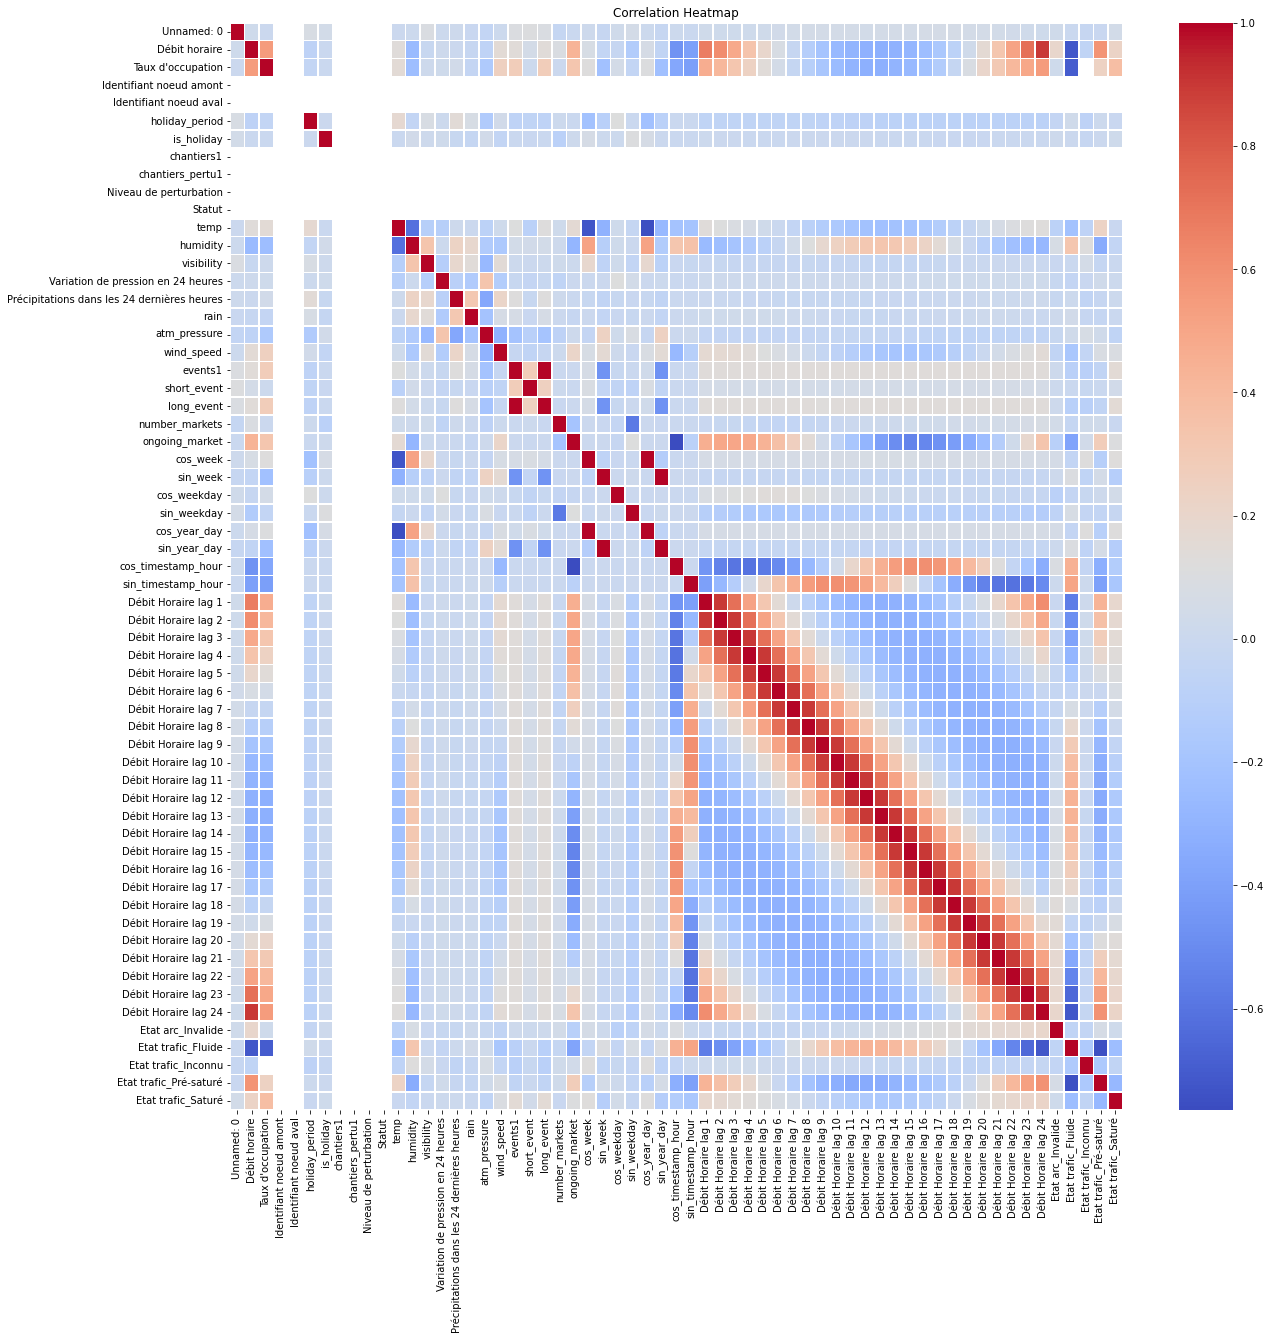

In [28]:
champs_numeric = champs_with_lags.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)
correlation_matrix = champs_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [35]:
def create_lags(df, dropnan=True):
    
    # input sequence (t-n, ... t-1)
    
    df['Lag1'] = df['Débit horaire'].shift(1)
    df['Lag24'] = df['Débit horaire'].shift(24)
    df['Lag168'] = df['Débit horaire'].shift(168)
    
    if dropnan:
        df = df.dropna()
    
    return df

In [36]:
def walk_forward_validation(data, n_test):
    
    predictions = list()
    # split dataset
    
    data = create_lags(data, dropnan=True)
    
    train, test = train_test_split(data, n_test)
    
    trainX, trainy = train.drop(columns=["Débit horaire", "Taux d'occupation"], errors='ignore'), train['Débit horaire']
    print(trainX.columns)
    
    ytrue = test['Débit horaire']
    
    trainX_arr = np.asarray(trainX)
    trainy_arr = np.asarray(trainy)
    
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX_arr, trainy_arr)
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test.drop(columns=["Débit horaire", "Taux d'occupation"], errors='ignore'), test['Débit horaire']
        testX_row = testX.iloc[i,:]
        testy_row = testy.iloc[i]

        # fit model on history and make a prediction
        yhat_ls = model.predict([testX_row])
        yhat = yhat_ls[0]

        test.loc[i, 'Débit horaire'] = yhat
        
        data = pd.concat([train, test], ignore_index=True)
        data = create_lags(data, dropnan=False)
        train, test = train_test_split(data, n_test)
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy_row, yhat))
        
    # estimate prediction error
    error = mean_squared_error(ytrue, predictions)
    return error, ytrue, predictions, data


In [37]:
def xgboost_forecast(train, testX):

    # split into input and output columns
    trainX, trainy = train.drop(columns=["Débit horaire", "Taux d'occupation"], errors='ignore'), train['Débit horaire']
    
    trainX = np.asarray(trainX)
    trainy = np.asarray(trainy)
    
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [38]:
def train_test_split(data, n_test):
    return data.iloc[:-n_test, :], data.iloc[-n_test:, :]

In [39]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

champs_preproc = champs
champs_preproc["temp"] = champs_preproc["temp"].interpolate(method='linear')
champs_preproc["humidity"] = champs_preproc["humidity"].interpolate(method='linear')
champs_preproc["visibility"] = champs_preproc["visibility"].interpolate(method='linear')
champs_preproc["rain"] = champs_preproc["rain"].interpolate(method='linear')
champs_preproc["wind_speed"] = champs_preproc["wind_speed"].interpolate(method='linear')

champs_preproc = champs_preproc.drop(columns=['holiday', 'Date et heure de comptage', 'Unnamed: 0', 'Libelle', 'date', 'yearmonth', 'day_of_week'])


In [40]:
mae, y, yhat, data = walk_forward_validation(champs_preproc, 72)
print('MAE: %.3f' % mae)


Index(['arrondissement', 'temp', 'humidity', 'rain', 'wind_speed',
       'visibility', 'holiday_period', 'is_holiday', 'chantiers1',
       'chantiers_pertu1', 'Niveau de perturbation', 'events1', 'short_event',
       'long_event', 'year', 'quarter', 'month', 'day_of_month', 'week',
       'weekday', 'number_markets', 'starting_hour', 'stopping_hour',
       'timestamp_hour', 'ongoing_market', 'year_day', 'cos_week', 'sin_week',
       'cos_weekday', 'sin_weekday', 'cos_year_day', 'sin_year_day',
       'cos_timestamp_hour', 'sin_timestamp_hour', 'Lag1', 'Lag24', 'Lag168'],
      dtype='object')


<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be 

>expected=993.0, predicted=724.3
>expected=916.0, predicted=743.6
>expected=458.0, predicted=392.2
>expected=679.0, predicted=740.5
>expected=1141.0, predicted=1198.1
>expected=1223.0, predicted=1250.3
>expected=1236.0, predicted=1258.6
>expected=1194.0, predicted=1204.2
>expected=1375.0, predicted=1272.3
>expected=1269.0, predicted=1452.1
>expected=1103.0, predicted=1142.0
>expected=867.0, predicted=918.8
>expected=624.0, predicted=629.5
>expected=664.0, predicted=472.0
>expected=261.0, predicted=360.8
>expected=777.0, predicted=829.3
>expected=1408.0, predicted=1294.6
>expected=1400.0, predicted=1412.1
>expected=1346.0, predicted=1455.9
>expected=1214.0, predicted=1226.3
>expected=1258.0, predicted=1429.9


<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be 

>expected=1456.0, predicted=1370.1
>expected=1206.0, predicted=1251.3
>expected=1292.0, predicted=920.0
>expected=846.0, predicted=945.4
>expected=421.0, predicted=545.0
>expected=264.0, predicted=300.1
>expected=885.0, predicted=1024.1
>expected=1364.0, predicted=1331.4
>expected=1327.0, predicted=1392.8
>expected=1461.0, predicted=1325.1
>expected=1420.0, predicted=1356.9
>expected=1158.0, predicted=1305.1
>expected=1208.0, predicted=1337.5
>expected=1167.0, predicted=1091.9
>expected=836.0, predicted=1173.1
>expected=724.3, predicted=755.5
>expected=392.2, predicted=634.0
>expected=1198.1, predicted=669.8
>expected=1258.6, predicted=1163.1
>expected=1272.3, predicted=1119.8
>expected=1142.0, predicted=1241.2


<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be 

>expected=629.5, predicted=1090.5
>expected=360.8, predicted=724.4
>expected=1294.6, predicted=791.6
>expected=1455.9, predicted=1174.0
>expected=1429.9, predicted=1157.9
>expected=1251.3, predicted=1177.7
>expected=945.4, predicted=1098.6
>expected=300.1, predicted=536.6
>expected=1331.4, predicted=1010.7
>expected=1325.1, predicted=1122.8
>expected=1305.1, predicted=1150.6
>expected=1091.9, predicted=1080.9
>expected=755.5, predicted=1142.4
>expected=669.8, predicted=547.0
>expected=1119.8, predicted=1155.0
>expected=1090.5, predicted=1199.4
>expected=791.6, predicted=746.2
>expected=1157.9, predicted=1133.6
>expected=1098.6, predicted=1147.0
>expected=1010.7, predicted=614.3
>expected=1150.6, predicted=1080.1
>expected=1142.4, predicted=1039.2
>expected=1155.0, predicted=674.4
>expected=746.2, predicted=1129.2
>expected=1147.0, predicted=1156.0
>expected=1080.1, predicted=766.1
>expected=674.4, predicted=1052.7
>expected=1156.0, predicted=1233.7
>expected=1052.7, predicted=659.8
>ex

<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'Débit horaire'] = yhat
<ipython-input-36-247b2a01bd34>:33: SettingWithCopyWarning: 
A value is trying to be 

439.23730414879947


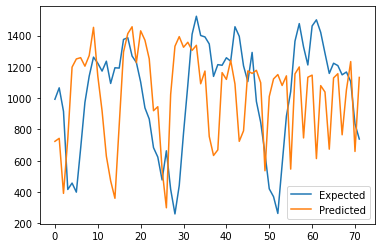

In [41]:
rmse = np.sqrt(mae)
print(rmse)
y_res = y.reset_index(drop=True)
# plot expected vs preducted
plt.plot(y_res, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [190]:
mae, y, yhat = walk_forward_validation(champs_numeric, 72)
print('MAE: %.3f' % mae)

>expected=615.0, predicted=503.2
>expected=439.0, predicted=410.0
>expected=273.0, predicted=276.9
>expected=212.0, predicted=188.7
>expected=361.0, predicted=207.0
>expected=367.0, predicted=584.7
>expected=677.0, predicted=675.4
>expected=1381.0, predicted=1090.1
>expected=1398.0, predicted=1414.5
>expected=1374.0, predicted=1395.2
>expected=1305.0, predicted=1369.8
>expected=1342.0, predicted=1283.0
>expected=1331.0, predicted=1327.5
>expected=1282.0, predicted=1264.6
>expected=1269.0, predicted=1358.0
>expected=1322.0, predicted=1236.3
>expected=1416.0, predicted=1290.3
>expected=1337.0, predicted=1323.6
>expected=1383.0, predicted=1273.3
>expected=1400.0, predicted=1335.2
>expected=1258.0, predicted=1231.4
>expected=928.0, predicted=1018.1
>expected=880.0, predicted=847.0
>expected=772.0, predicted=694.5
>expected=948.0, predicted=655.0
>expected=1621.0, predicted=906.3
>expected=631.0, predicted=1237.0
>expected=261.0, predicted=527.4
>expected=219.0, predicted=350.3
>expected=56

176.4607910155455


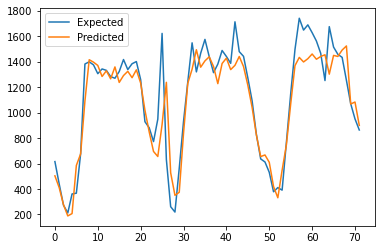

In [191]:
rmse = np.sqrt(mae)
print(rmse)
y_res = y.reset_index(drop=True)
# plot expected vs preducted
plt.plot(y_res, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

165.5031715970041


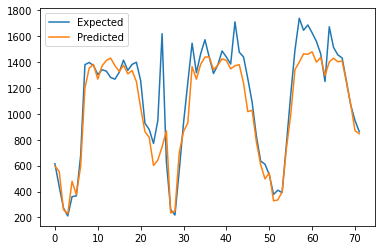

In [14]:
champs_numeric = champs.drop(columns=['Libelle', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

champs_numeric = pd.get_dummies(champs_numeric, columns=['Etat arc', 'Etat trafic'], drop_first=True)

train, test = champs_numeric.iloc[:-72, :], champs_numeric.iloc[-72:, :]

trainX, trainy = train.loc[:, train.columns != 'Débit horaire'], train.loc[:, ['Débit horaire']]
testX, testy = test.loc[:, test.columns != 'Débit horaire'], test.loc[:, ['Débit horaire']]


trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy = np.asarray(testy)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat = model.predict(testX)

error = mean_squared_error(testy, yhat)

rmse = np.sqrt(error)
print(rmse)
# plot expected vs preducted
plt.plot(testy, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()


In [180]:
print(champs_numeric.columns)

Index(['Unnamed: 0', 'Débit horaire', 'Taux d'occupation',
       'Identifiant noeud amont', 'Identifiant noeud aval', 'holiday_period',
       'is_holiday', 'chantiers1', 'chantiers_pertu1',
       'Niveau de perturbation', 'Statut', 'temp', 'humidity', 'visibility',
       'Variation de pression en 24 heures',
       'Précipitations dans les 24 dernières heures', 'rain', 'atm_pressure',
       'wind_speed', 'events1', 'short_event', 'long_event', 'number_markets',
       'ongoing_market', 'cos_week', 'sin_week', 'cos_weekday', 'sin_weekday',
       'cos_year_day', 'sin_year_day', 'cos_timestamp_hour',
       'sin_timestamp_hour', 'Etat arc_Invalide', 'Etat trafic_Fluide',
       'Etat trafic_Inconnu', 'Etat trafic_Pré-saturé', 'Etat trafic_Saturé'],
      dtype='object')


250.65688260836916


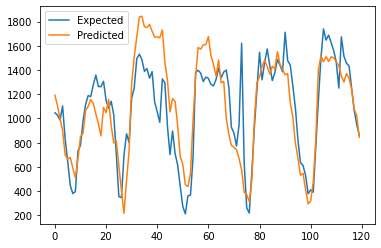

In [41]:
champs_numeric = champs.drop(columns=['Libelle', "Taux d'occupation", 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic', 'Variation de pression en 24 heures',
       'Précipitations dans les 24 dernières heures', 'Identifiant noeud amont',
       'Identifiant noeud aval', 'Unnamed: 0', 'year', 'quarter', 'month', 'day_of_month', 'week', 'weekday', 'starting_hour', 'stopping_hour', 'timestamp_hour', 'year_day', 'cosweek', 'sinweek', 'cosweekday', 'sinweekday', 'cosyear_day', 'sinyear_day', 'costimestamp_hour', 'sintimestamp_hour'], errors='ignore')

train, test = champs_numeric.iloc[:-120, :], champs_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != 'Débit horaire'], train.loc[:, ['Débit horaire']]
testX, testy = test.loc[:, test.columns != 'Débit horaire'], test.loc[:, ['Débit horaire']]


trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy = np.asarray(testy)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat = model.predict(testX)

error = mean_squared_error(testy, yhat)

rmse = np.sqrt(error)
print(rmse)
# plot expected vs preducted
plt.plot(testy, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [23]:
train.columns

Index(['Débit horaire', 'holiday_period', 'is_holiday', 'chantiers1',
       'chantiers_pertu1', 'Niveau de perturbation', 'Statut', 'temp',
       'humidity', 'visibility', 'rain', 'atm_pressure', 'wind_speed',
       'events1', 'short_event', 'long_event', 'year', 'quarter', 'month',
       'day_of_month', 'week', 'weekday', 'number_markets', 'starting_hour',
       'stopping_hour', 'timestamp_hour', 'ongoing_market', 'year_day',
       'cosweek', 'sinweek', 'cosweekday', 'sinweekday', 'cosyear_day',
       'sinyear_day', 'costimestamp_hour', 'sintimestamp_hour', 'cos_week',
       'sin_week', 'cos_weekday', 'sin_weekday', 'cos_year_day',
       'sin_year_day', 'cos_timestamp_hour', 'sin_timestamp_hour'],
      dtype='object')

78.24738684956417


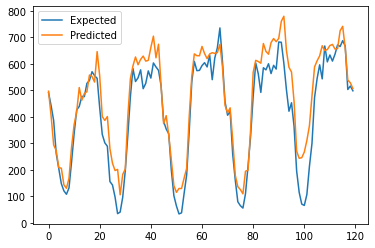

In [47]:
st_peres['Débit horaire'] = st_peres['Débit horaire'].interpolate(method='linear')
st_peres["Taux d'occupation"] = st_peres["Taux d'occupation"].interpolate(method='linear')
st_peres["temp"] = st_peres["temp"].interpolate(method='linear')
st_peres["humidity"] = st_peres["humidity"].interpolate(method='linear')
st_peres["visibility"] = st_peres["visibility"].interpolate(method='linear')
st_peres["Variation de pression en 24 heures"] = st_peres["Variation de pression en 24 heures"].interpolate(method='linear')
st_peres["Précipitations dans les 24 dernières heures"] = st_peres["Précipitations dans les 24 dernières heures"].interpolate(method='linear')
st_peres["rain"] = st_peres["rain"].interpolate(method='linear')
st_peres["atm_pressure"] = st_peres["atm_pressure"].interpolate(method='linear')
st_peres["wind_speed"] = st_peres["wind_speed"].interpolate(method='linear')

st_peres_numeric = st_peres.drop(columns=['Libelle', "Taux d'occupation", 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic'], errors='ignore')

train, test = st_peres_numeric.iloc[:-120, :], st_peres_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != 'Débit horaire'], train.loc[:, ['Débit horaire']]
testX, testy2 = test.loc[:, test.columns != 'Débit horaire'], test.loc[:, ['Débit horaire']]

trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy2 = np.asarray(testy2)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat2 = model.predict(testX)

error2 = mean_squared_error(testy2, yhat2)

rmse2 = np.sqrt(error2)
print(rmse2)
# plot expected vs preducted
plt.plot(testy2, label='Expected')
plt.plot(yhat2, label='Predicted')
plt.legend()
plt.show()

22.91308759450987


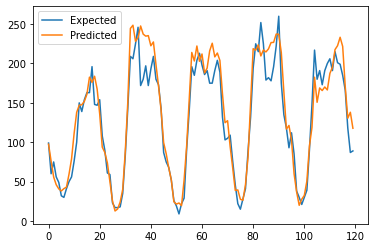

In [48]:
convention['Débit horaire'] = convention['Débit horaire'].interpolate(method='linear')
convention["Taux d'occupation"] = convention["Taux d'occupation"].interpolate(method='linear')
convention["temp"] = convention["temp"].interpolate(method='linear')
convention["humidity"] = convention["humidity"].interpolate(method='linear')
convention["visibility"] = convention["visibility"].interpolate(method='linear')
convention["Variation de pression en 24 heures"] = convention["Variation de pression en 24 heures"].interpolate(method='linear')
convention["Précipitations dans les 24 dernières heures"] = convention["Précipitations dans les 24 dernières heures"].interpolate(method='linear')
convention["rain"] = convention["rain"].interpolate(method='linear')
convention["atm_pressure"] = convention["atm_pressure"].interpolate(method='linear')
convention["wind_speed"] = convention["wind_speed"].interpolate(method='linear')

convention_numeric = convention.drop(columns=['Libelle', "Taux d'occupation", 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic'], errors='ignore')

train, test = convention_numeric.iloc[:-120, :], convention_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != 'Débit horaire'], train.loc[:, ['Débit horaire']]
testX, testy3 = test.loc[:, test.columns != 'Débit horaire'], test.loc[:, ['Débit horaire']]

trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy3 = np.asarray(testy3)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat3 = model.predict(testX)

error3 = mean_squared_error(testy3, yhat3)

rmse3 = np.sqrt(error3)
print(rmse3)
# plot expected vs preducted
plt.plot(testy3, label='Expected')
plt.plot(yhat3, label='Predicted')
plt.legend()
plt.show()

13.7339952688454


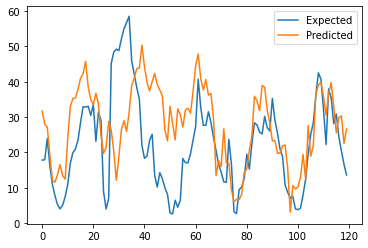

In [49]:
champs_numeric = champs.drop(columns=['Libelle', 'Débit horaire', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic'], errors='ignore')

train, test = champs_numeric.iloc[:-120, :], champs_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != "Taux d'occupation"], train.loc[:, ["Taux d'occupation"]]
testX, testy_tx = test.loc[:, test.columns != "Taux d'occupation"], test.loc[:, ["Taux d'occupation"]]

trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy_tx = np.asarray(testy_tx)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat4 = model.predict(testX)

error4 = mean_squared_error(testy_tx, yhat4)

rmse4 = np.sqrt(error4)
print(rmse4)
# plot expected vs preducted
plt.plot(testy_tx, label='Expected')
plt.plot(yhat4, label='Predicted')
plt.legend()
plt.show()

2.2603398376479205


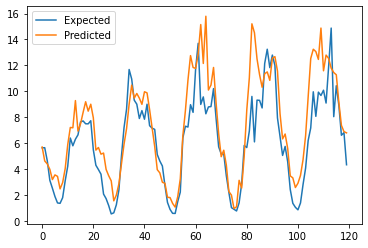

In [50]:
st_peres_numeric = st_peres.drop(columns=['Libelle', 'Débit horaire', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic'], errors='ignore')

train, test = st_peres_numeric.iloc[:-120, :], st_peres_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != "Taux d'occupation"], train.loc[:, ["Taux d'occupation"]]
testX, testy_tx2 = test.loc[:, test.columns != "Taux d'occupation"], test.loc[:, ["Taux d'occupation"]]

trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy_tx2 = np.asarray(testy_tx2)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat5 = model.predict(testX)

error5 = mean_squared_error(testy_tx2, yhat5)

rmse5 = np.sqrt(error5)
print(rmse5)
# plot expected vs preducted
plt.plot(testy_tx2, label='Expected')
plt.plot(yhat5, label='Predicted')
plt.legend()
plt.show()

1.6704471380104557


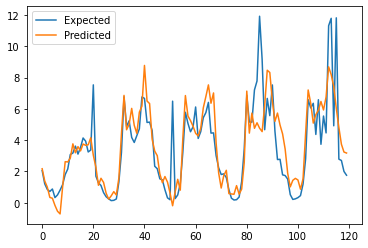

In [51]:
convention_numeric = convention.drop(columns=['Libelle', 'Débit horaire', 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic'], errors='ignore')

train, test = convention_numeric.iloc[:-120, :], convention_numeric.iloc[-120:, :]

trainX, trainy = train.loc[:, train.columns != "Taux d'occupation"], train.loc[:, ["Taux d'occupation"]]
testX, testy_tx3 = test.loc[:, test.columns != "Taux d'occupation"], test.loc[:, ["Taux d'occupation"]]

trainX = np.asarray(trainX)
trainy = np.asarray(trainy)
testX = np.asarray(testX)
testy_tx3 = np.asarray(testy_tx3)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

yhat6 = model.predict(testX)

error6 = mean_squared_error(testy_tx3, yhat6)

rmse6 = np.sqrt(error6)
print(rmse6)
# plot expected vs preducted
plt.plot(testy_tx3, label='Expected')
plt.plot(yhat6, label='Predicted')
plt.legend()
plt.show()

RMSE for Debit Champs :  223.70539267831387
RMSE for Taux Champs :  13.7339952688454
RMSE for Debit Saint-Pères :  78.24738684956417
RMSE for Taux Saint-Pères :  2.2603398376479205
RMSE for Debit Convention :  22.91308759450987
RMSE for Taux Convention :  1.6704471380104557


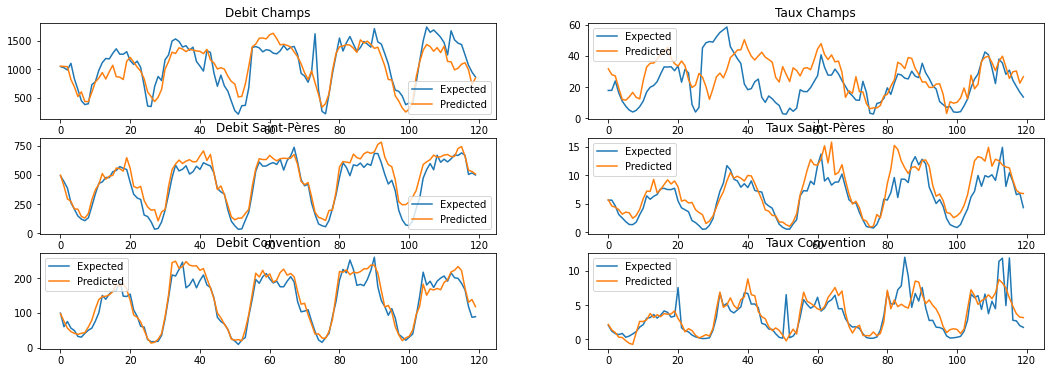

In [52]:
print("RMSE for Debit Champs : ", rmse)
print("RMSE for Taux Champs : ", rmse4)
print("RMSE for Debit Saint-Pères : ", rmse2)
print("RMSE for Taux Saint-Pères : ", rmse5)
print("RMSE for Debit Convention : ", rmse3)
print("RMSE for Taux Convention : ", rmse6)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 6))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': testy, 'yhat': yhat},
    {'testy': testy_tx, 'yhat': yhat4},
    {'testy': testy2, 'yhat': yhat2},
    {'testy': testy_tx2, 'yhat': yhat5},
    {'testy': testy3, 'yhat': yhat3},
    {'testy': testy_tx3, 'yhat': yhat6}
]

titles = [
    'Debit Champs',
    'Taux Champs',
    'Debit Saint-Pères',
    'Taux Saint-Pères',
    'Debit Convention',
    'Taux Convention'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.plot(data['testy'], label='Expected')
    ax.plot(data['yhat'], label='Predicted')
    ax.legend()
    
    ax.set_title(titles[i])

In [25]:
champs_test = traffic_reel[traffic_reel['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["Date et heure de comptage"], ascending=True)
st_peres_test = traffic_reel[traffic_reel['Libelle'] == "Sts_Peres"].sort_values(by=["Date et heure de comptage"], ascending=True)
convention_test = traffic_reel[traffic_reel['Libelle'] == "Convention"].sort_values(by=["Date et heure de comptage"], ascending=True)



Index(['holiday_period', 'is_holiday', 'chantiers1', 'chantiers_pertu1',
       'Niveau de perturbation', 'Statut', 'temp', 'humidity', 'visibility',
       'rain', 'atm_pressure', 'wind_speed', 'events1', 'short_event',
       'long_event', 'number_markets', 'ongoing_market', 'cos_week',
       'sin_week', 'cos_weekday', 'sin_weekday', 'cos_year_day',
       'sin_year_day', 'cos_timestamp_hour', 'sin_timestamp_hour'],
      dtype='object')
39.477258362685525


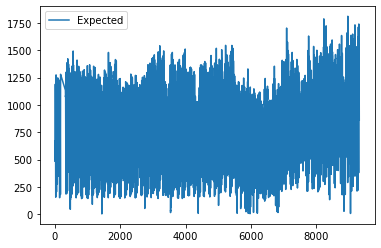

In [42]:
champs_test['Real Debit'] = champs_test['Real Debit'].interpolate(method='linear')
champs_test["Taux d'occupation"] = champs_test["Taux d'occupation"].interpolate(method='linear')
champs_test["temp"] = champs_test["temp"].interpolate(method='linear')
champs_test["humidity"] = champs_test["humidity"].interpolate(method='linear')
champs_test["visibility"] = champs_test["visibility"].interpolate(method='linear')
champs_test["Variation de pression en 24 heures"] = champs_test["Variation de pression en 24 heures"].interpolate(method='linear')
champs_test["Précipitations dans les 24 dernières heures"] = champs_test["Précipitations dans les 24 dernières heures"].interpolate(method='linear')
champs_test["rain"] = champs_test["rain"].interpolate(method='linear')
champs_test["atm_pressure"] = champs_test["atm_pressure"].interpolate(method='linear')
champs_test["wind_speed"] = champs_test["wind_speed"].interpolate(method='linear')

champs_test_numeric = champs_test.drop(columns=['Libelle', "Taux d'occupation", 'Date et heure de comptage', 'Libelle noeud amont', 'Libelle noeud aval', 'date', 'timestamp', 'timestamp_short', 'arrondissement','Identifiant arc', 'holiday', 'yearmonth', 'day_of_week', 'Etat arc', 'Etat trafic', 'Variation de pression en 24 heures',
       'Précipitations dans les 24 dernières heures', 'Identifiant noeud amont',
       'Identifiant noeud aval', 'Unnamed: 0'], errors='ignore')

champs_test_X, champs_test_y = champs_test_numeric.loc[:, champs_test_numeric.columns != 'Real Debit'], champs_test_numeric.loc[:, ['Real Debit']]

print(champs_test_X.columns)

champs_test_X = np.asarray(champs_test_X)
champs_test_y = np.asarray(champs_test_y)

yhat_test = model.predict(champs_test_X)

error_test = mean_squared_error(champs_test_y, yhat_test)

rmse_test = np.sqrt(error_test)
print(rmse_test)
# plot expected vs preducted
plt.plot(champs_test_y, label='Expected')
plt.plot(yhat_test = model.predict(champs_test_X)
, label='Predicted')
plt.legend()
plt.show()

In [36]:
A = ['holiday_period', 'is_holiday', 'chantiers1', 'chantiers_pertu1',
       'Niveau de perturbation', 'Statut', 'temp', 'humidity', 'visibility',
       'rain', 'atm_pressure', 'wind_speed', 'events1', 'short_event',
       'long_event', 'year', 'quarter', 'month', 'day_of_month', 'week',
       'weekday', 'number_markets', 'starting_hour', 'stopping_hour',
       'timestamp_hour', 'ongoing_market', 'year_day', 'cosweek', 'sinweek',
       'cosweekday', 'sinweekday', 'cosyear_day', 'sinyear_day',
       'costimestamp_hour', 'sintimestamp_hour', 'cos_week', 'sin_week',
       'cos_weekday', 'sin_weekday', 'cos_year_day', 'sin_year_day',
]

B = ['holiday_period', 'is_holiday', 'chantiers1', 'chantiers_pertu1',
       'Niveau de perturbation', 'Statut', 'temp', 'humidity', 'visibility',
       'rain', 'atm_pressure', 'wind_speed', 'events1', 'short_event',
       'long_event', 'number_markets', 'ongoing_market', 'cos_week',
       'sin_week', 'cos_weekday', 'sin_weekday', 'cos_year_day',
       'sin_year_day', 'cos_timestamp_hour', 'sin_timestamp_hour']

C = []

for l in A:
    if l not in B:
        C.append(l)
print(C)

['year', 'quarter', 'month', 'day_of_month', 'week', 'weekday', 'starting_hour', 'stopping_hour', 'timestamp_hour', 'year_day', 'cosweek', 'sinweek', 'cosweekday', 'sinweekday', 'cosyear_day', 'sinyear_day', 'costimestamp_hour', 'sintimestamp_hour']
